# **Import Data**

In [1]:
!kaggle competitions download -c data-analytics-competition-find-it-2024

data-analytics-competition-find-it-2024.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
#import zipfile module
from zipfile import ZipFile

with ZipFile('data-analytics-competition-find-it-2024.zip', 'r') as f:
    #extract in current directory
    f.extractall()

# **Libraries**

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer
from sklearn.preprocessing import RobustScaler
from scipy import stats
from scipy.stats import spearmanr

# Modelling
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# Model Evaluation
from sklearn.metrics import f1_score, classification_report

# **Data Loading**

In [4]:
df_train = pd.read_csv("train_features.csv")
df_train

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17
2,1966,Sarjana,Menikah,127532564.0,0.0,0.0,45.0,117611.0,265460.0,96341.0,145573.0,1.0,1.0,7.0,0.0,NaN
3,1961,Magister,Rencana Menikah,165579620.0,0.0,0.0,90.0,206346.0,1613901.0,27725.0,125868.0,0.0,7.0,8.0,0.0,NaN
4,1970,Sarjana,Rencana Menikah,117703159.0,1.0,1.0,78.0,90563.0,311757.0,40358.0,33875.0,7.0,6.0,5.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3812,1955,Magister,Menikah,78199470.0,0.0,0.0,33.0,6069.0,25977.0,3856.0,5784.0,5.0,1.0,0.0,0.0,NaN
3813,1947,Doktor,Rencana Menikah,109306000.0,0.0,1.0,44.0,0.0,50575.0,NaN,0.0,3.0,6.0,3.0,0.0,2014-06-09
3814,1974,Magister,Menikah,104621000.0,0.0,2.0,68.0,2023.0,62713.0,8092.0,0.0,7.0,5.0,7.0,0.0,2013-11-07
3815,1957,SMA,Rencana Menikah,110850000.0,1.0,1.0,67.0,18207.0,70805.0,24276.0,NaN,4.0,5.0,4.0,0.0,2013-06-30


**Insight :** Terdapat 3817 baris dan 16 kolom/fitur pada data train

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3817 entries, 0 to 3816
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tahun_kelahiran          3817 non-null   int64  
 1   pendidikan               3628 non-null   object 
 2   status_pernikahan        3605 non-null   object 
 3   pendapatan               3627 non-null   float64
 4   jumlah_anak_balita       3627 non-null   float64
 5   jumlah_anak_remaja       3613 non-null   float64
 6   terakhir_belanja         3645 non-null   float64
 7   belanja_buah             3636 non-null   float64
 8   belanja_daging           3639 non-null   float64
 9   belanja_ikan             3624 non-null   float64
 10  belanja_kue              3603 non-null   float64
 11  pembelian_diskon         3639 non-null   float64
 12  pembelian_web            3652 non-null   float64
 13  pembelian_toko           3648 non-null   float64
 14  keluhan                 

**Insight :** 
1. Dengan jumlah baris 3817 pada data train, semua memiliki missing value terkecuali fitur tahun_kelahiran
2. Fitur tanggal_menjadi_anggota seharusnya memiliki tipe data datetime

In [6]:
df_train.describe()

,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan
count,3817.000000,3.627000e+03,3627.000000,3613.000000,3645.000000,3636.000000,3.639000e+03,3624.000000,3603.000000,3639.000000,3652.000000,3648.000000,3621.000000
mean,1967.823946,1.144832e+08,0.293080,0.353723,47.231550,59804.239824,4.385748e+05,81428.997792,63377.970580,2.125584,4.436473,5.767818,0.004971
std,11.768131,4.346042e+07,0.473063,0.493014,27.068512,74024.976109,5.120427e+05,99976.226855,79435.457282,2.100133,3.002522,3.210738,0.070340
min,1899.000000,5.073000e+06,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,8.112512e+07,0.000000,0.000000,25.000000,7907.000000,4.947950e+04,10115.000000,7947.000000,0.000000,2.000000,3.000000,0.000000
50%,1968.000000,1.156214e+08,0.000000,0.000000,47.000000,26456.000000,2.219930e+05,36054.500000,27795.000000,2.000000,4.000000,5.000000,0.000000
75%,1976.000000,1.504960e+08,1.000000,1.000000,69.000000,86162.000000,6.863555e+05,121380.000000,89502.500000,3.000000,7.000000,8.000000,0.000000
max,2000.000000,3.328840e+08,2.000000,2.000000,128.000000,396508.000000,3.489675e+06,621600.000000,542164.000000,20.000000,30.000000,17.000000,1.000000


**Insight :** 
1. Beberapa fitur memiliki kemungkinan distribusi normal dikarenakan memiliki perbedaan nilai yang tidak terlalu jauh
2. Fitur fitur belanja yang mengenai harga kemungkinan tinggi memiliki outlier dan distribusinya skew
3. Perlu dilakukan scaling dikarenakan beberpa fitur memiliki perbedaan nilai yang tinggi

In [7]:
df_train.duplicated().sum()

0

In [8]:
y_train = pd.read_csv("train_labels.csv")
y_train

,jumlah_promosi
0,2
1,0
2,1
3,4
4,4
...,...
3812,5
3813,1
3814,0
3815,0


# **EDA**

1. Bagaimana missing value terjadi?
2. Bagaimana distribusi data masing masing fitur?
3. Apakah terdapat outlier?
4. Apakah datanya balance?

## 1. Bagaimana missing value terjadi?

### pendidikan

In [11]:
df_train['pendidikan'].value_counts()

pendidikan
Sarjana     1841
Magister     856
SMA          435
Doktor       403
SMP           91
5              2
Name: count, dtype: int64

In [12]:
ms_1 = df_train[df_train['pendidikan'].isna()]
ms_1.tail(5)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
3716,1974,NaN,Cerai,25169000.0,1.0,0.0,85.0,6069.0,28322.0,14161.0,32368.0,6.0,5.0,4.0,0.0,2014-01-17
3723,1973,NaN,Rencana Menikah,50022737.0,1.0,0.0,68.0,9162.0,8907.0,9383.0,12614.0,0.0,3.0,2.0,0.0,NaN
3738,1977,NaN,Sendiri,64076000.0,1.0,0.0,5.0,8092.0,8092.0,28322.0,22253.0,0.0,0.0,5.0,0.0,2014-02-28
3797,1982,NaN,Sendiri,120689156.0,0.0,0.0,74.0,NaN,350942.0,44583.0,17614.0,2.0,5.0,12.0,0.0,NaN
3801,1973,NaN,Sendiri,171296541.0,0.0,0.0,38.0,38261.0,661232.0,362908.0,51052.0,1.0,10.0,10.0,0.0,NaN


In [15]:
df_train.keluhan.value_counts()

keluhan
0.0    3603
1.0      18
Name: count, dtype: int64

In [18]:
print(ms_1.status_pernikahan.value_counts())
print(ms_1.jumlah_anak_remaja.value_counts())
print(ms_1.keluhan.value_counts())

status_pernikahan
Menikah            60
Sendiri            54
Rencana Menikah    45
Cerai              15
Cerai Mati          1
Name: count, dtype: int64
jumlah_anak_remaja
0.0    125
1.0     54
2.0      1
Name: count, dtype: int64
keluhan
0.0    183
Name: count, dtype: int64


In [21]:
df_train[df_train['keluhan'] == 0.0]['pendidikan'].value_counts()

pendidikan
Sarjana     1739
Magister     808
SMA          403
Doktor       385
SMP           83
5              2
Name: count, dtype: int64

MV pada pendidikan akan diisi dengan `Sarjana`

### status pernikahan

In [24]:
df_train['status_pernikahan'].value_counts()

status_pernikahan
Rencana Menikah    1271
Menikah            1114
Sendiri             965
Cerai               214
Cerai Mati           40
5                     1
Name: count, dtype: int64

In [23]:
mv_1 = df_train[df_train['status_pernikahan'].isna()]
mv_1.tail(5)

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
3702,1970,Doktor,NaN,NaN,0.0,1.0,15.0,9340.0,43572.0,26253.0,14830.0,1.0,8.0,8.0,0.0,NaN
3748,1970,SMA,NaN,103519953.0,0.0,0.0,61.0,73586.0,287142.0,125411.0,129457.0,2.0,4.0,6.0,0.0,NaN
3796,1970,Doktor,NaN,73194000.0,1.0,1.0,41.0,0.0,16184.0,18207.0,0.0,0.0,3.0,NaN,0.0,2014-05-18
3806,1958,Sarjana,NaN,109027112.0,0.0,1.0,97.0,15945.0,164454.0,13327.0,952.0,4.0,10.0,5.0,0.0,NaN
3808,1963,Magister,NaN,117190625.0,0.0,1.0,69.0,2545.0,106247.0,1044.0,11880.0,1.0,3.0,11.0,0.0,NaN


In [46]:
print("\nDoktor : ",df_train[(df_train['pendidikan'] == "Doktor")]['status_pernikahan'].value_counts())
print("\nSMA : ",df_train[(df_train['pendidikan'] == "SMA")]['status_pernikahan'].value_counts())
print("\nSarjana : ",df_train[(df_train['pendidikan'] == "Sarjana")]['status_pernikahan'].value_counts())
print("\nMagister : ",df_train[(df_train['pendidikan'] == "Magister")]['status_pernikahan'].value_counts())
print("\nSMA : ",df_train[(df_train['pendidikan'] == "SMA")]['status_pernikahan'].value_counts())
print("\nSMP : ",df_train[(df_train['pendidikan'] == "SMP")]['status_pernikahan'].value_counts())


Doktor :  status_pernikahan
Menikah            152
Rencana Menikah    107
Sendiri             77
Cerai               31
Cerai Mati          11
5                    1
Name: count, dtype: int64

SMA :  status_pernikahan
Rencana Menikah    158
Menikah            125
Sendiri            102
Cerai               16
Name: count, dtype: int64

Sarjana :  status_pernikahan
Rencana Menikah    612
Menikah            531
Sendiri            498
Cerai               90
Cerai Mati          20
Name: count, dtype: int64

Magister :  status_pernikahan
Rencana Menikah    316
Menikah            226
Sendiri            201
Cerai               62
Cerai Mati           7
Name: count, dtype: int64

SMA :  status_pernikahan
Rencana Menikah    158
Menikah            125
Sendiri            102
Cerai               16
Name: count, dtype: int64

SMP :  status_pernikahan
Rencana Menikah    33
Sendiri            32
Menikah            19
Cerai Mati          1
Name: count, dtype: int64


Imputasi akan dilakukan sesuai dengan `pendidikan`

### pendapatan

In [ ]:
ms_1 = df_train[df_train['pendapatan'].isna()]
ms_1

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
23,1982,SMA,Rencana Menikah,NaN,1.0,0.0,54.0,8742.0,26206.0,4231.0,836.0,3.0,2.0,2.0,0.0,NaN
53,1975,Doktor,Menikah,NaN,0.0,0.0,65.0,180047.0,1488928.0,145656.0,105196.0,1.0,1.0,7.0,0.0,NaN
116,1957,SMA,Rencana Menikah,NaN,0.0,1.0,30.0,15143.0,61788.0,4104.0,0.0,4.0,5.0,8.0,0.0,NaN
135,1976,Sarjana,Menikah,NaN,0.0,NaN,66.0,115311.0,1145018.0,226576.0,260967.0,2.0,6.0,7.0,0.0,2014-05-14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3719,1959,Doktor,Rencana Menikah,NaN,1.0,1.0,19.0,7985.0,33007.0,958.0,0.0,4.0,2.0,1.0,NaN,NaN
3747,1968,Sarjana,Sendiri,NaN,0.0,0.0,25.0,34958.0,906989.0,147607.0,66475.0,1.0,5.0,8.0,0.0,NaN
3766,1986,Magister,Cerai,NaN,0.0,0.0,38.0,10569.0,10478.0,10115.0,7728.0,2.0,3.0,1.0,0.0,NaN
3803,1969,Sarjana,Menikah,NaN,1.0,0.0,16.0,77055.0,362195.0,31759.0,29808.0,1.0,5.0,11.0,0.0,NaN


Missing value pada fitur `pendapatan` akan diimputasi dengan mean pada masing masing pendidikan

In [22]:
print(df_train['pendapatan'].min())
print(df_train['pendapatan'].median())
print(df_train['pendapatan'].max())
print(df_train['pendapatan'].mean())

5073000.0
115621394.0
332884000.0
114483170.08960573


MV pada fitur pendapatan akan diisi dengan `mean` dari pendapatan

### jumlah anak remaja

In [ ]:
ms_1 = df_train[df_train['jumlah_anak_remaja'].isna()]
ms_1

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17
6,1963,Magister,Sendiri,75313000.0,2.0,NaN,96.0,0.0,14161.0,8092.0,2023.0,1.0,4.0,5.0,0.0,2013-05-03
9,1975,Sarjana,Menikah,37567504.0,1.0,NaN,67.0,19061.0,28067.0,22223.0,14146.0,3.0,2.0,1.0,0.0,NaN
12,1957,Sarjana,Sendiri,152418000.0,0.0,NaN,5.0,149702.0,337841.0,93058.0,72828.0,3.0,10.0,2.0,0.0,2013-11-21
21,1965,Sarjana,Menikah,138197975.0,0.0,NaN,84.0,40357.0,214915.0,40670.0,43342.0,4.0,6.0,8.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3729,1975,Magister,Rencana Menikah,72537110.0,1.0,NaN,27.0,26465.0,43570.0,6555.0,755.0,2.0,2.0,4.0,0.0,NaN
3745,1975,SMA,Sendiri,51559463.0,1.0,NaN,24.0,12493.0,25109.0,33815.0,22007.0,1.0,2.0,NaN,0.0,NaN
3771,1948,Magister,Rencana Menikah,198018607.0,0.0,NaN,58.0,70474.0,1440714.0,155617.0,88035.0,0.0,6.0,7.0,0.0,NaN
3773,1975,SMP,Rencana Menikah,23664655.0,1.0,NaN,4.0,NaN,NaN,11259.0,24113.0,1.0,1.0,4.0,0.0,NaN


In [ ]:
print(df_train[df_train['status_pernikahan'] == "Menikah"]['jumlah_anak_remaja'].value_counts())
print(df_train[df_train['status_pernikahan'] == "Menikah"]['jumlah_anak_remaja'].mean())
print(df_train[df_train['status_pernikahan'] == "Menikah"]['jumlah_anak_remaja'].mode())
print(df_train[df_train['status_pernikahan'] == "Menikah"]['jumlah_anak_remaja'].median())

jumlah_anak_remaja
0.0    641
1.0    397
2.0     10
Name: count, dtype: int64
0.3979007633587786
0    0.0
Name: jumlah_anak_remaja, dtype: float64
0.0


In [ ]:
print(df_train[df_train['status_pernikahan'] == "Cerai"]['jumlah_anak_remaja'].value_counts())
print(df_train[df_train['status_pernikahan'] == "Cerai"]['jumlah_anak_remaja'].mean())
print(df_train[df_train['status_pernikahan'] == "Cerai"]['jumlah_anak_remaja'].mode())
print(df_train[df_train['status_pernikahan'] == "Cerai"]['jumlah_anak_remaja'].median())

jumlah_anak_remaja
0.0    110
1.0     83
2.0      3
Name: count, dtype: int64
0.45408163265306123
0    0.0
Name: jumlah_anak_remaja, dtype: float64
0.0


In [ ]:
print(df_train[df_train['status_pernikahan'] == "Cerai Mati"]['jumlah_anak_remaja'].value_counts())
print(df_train[df_train['status_pernikahan'] == "Cerai Mati"]['jumlah_anak_remaja'].mean())
print(df_train[df_train['status_pernikahan'] == "Cerai Mati"]['jumlah_anak_remaja'].mode())
print(df_train[df_train['status_pernikahan'] == "Cerai Mati"]['jumlah_anak_remaja'].median())

jumlah_anak_remaja
0.0    24
1.0    14
Name: count, dtype: int64
0.3684210526315789
0    0.0
Name: jumlah_anak_remaja, dtype: float64
0.0


**Insight :** Missing value pada fitur `jumlah_anak_remaja` akan diimputasi dengan 0 dikarenakan memiliki kemungkinan orang yang tidak mengisi tidak memiliki anak remaja

### jumlah anak balita

In [ ]:
ms_1 = df_train[df_train['jumlah_anak_balita'].isna()]
ms_1

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
1,1950,Sarjana,Rencana Menikah,84063000.0,NaN,NaN,70.0,6069.0,44506.0,80920.0,20230.0,9.0,6.0,4.0,0.0,2013-03-17
13,1979,SMP,Menikah,14967000.0,NaN,0.0,65.0,34391.0,30345.0,32368.0,0.0,0.0,5.0,2.0,0.0,2012-11-14
17,1973,Sarjana,Rencana Menikah,119766595.0,NaN,1.0,16.0,20230.0,181594.0,10650.0,51288.0,0.0,7.0,8.0,0.0,NaN
43,1954,Magister,Rencana Menikah,105339251.0,NaN,1.0,58.0,4046.0,154472.0,15851.0,442.0,7.0,9.0,4.0,0.0,NaN
52,1956,Magister,Rencana Menikah,190785436.0,NaN,0.0,59.0,77286.0,1082787.0,112601.0,19302.0,0.0,9.0,6.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3731,1990,SMA,Menikah,125535217.0,NaN,2.0,41.0,35834.0,NaN,NaN,103129.0,0.0,0.0,4.0,0.0,NaN
3783,1966,Magister,Rencana Menikah,65730000.0,NaN,1.0,10.0,0.0,52598.0,NaN,0.0,2.0,4.0,NaN,0.0,2012-09-07
3792,1956,Doktor,Rencana Menikah,136934000.0,NaN,2.0,86.0,76874.0,NaN,24276.0,0.0,5.0,13.0,3.0,0.0,2013-03-07
3795,1987,SMA,Menikah,165167035.0,NaN,0.0,20.0,NaN,674183.0,54447.0,53628.0,2.0,3.0,8.0,0.0,NaN


In [ ]:
ms_1['status_pernikahan'].value_counts()

status_pernikahan
Menikah            63
Rencana Menikah    51
Sendiri            48
Cerai              11
Cerai Mati          2
Name: count, dtype: int64

In [ ]:
print(df_train[df_train['status_pernikahan'] == "Cerai"]['jumlah_anak_balita'].value_counts())
print(df_train[df_train['status_pernikahan'] == "Cerai"]['jumlah_anak_balita'].mean())
print(df_train[df_train['status_pernikahan'] == "Cerai"]['jumlah_anak_balita'].mode())
print(df_train[df_train['status_pernikahan'] == "Cerai"]['jumlah_anak_balita'].median())

jumlah_anak_balita
0.0    152
1.0     49
2.0      2
Name: count, dtype: int64
0.26108374384236455
0    0.0
Name: jumlah_anak_balita, dtype: float64
0.0


In [ ]:
print(df_train[df_train['status_pernikahan'] == "Cerai Mati"]['jumlah_anak_balita'].value_counts())
print(df_train[df_train['status_pernikahan'] == "Cerai Mati"]['jumlah_anak_balita'].mean())
print(df_train[df_train['status_pernikahan'] == "Cerai Mati"]['jumlah_anak_balita'].mode())
print(df_train[df_train['status_pernikahan'] == "Cerai Mati"]['jumlah_anak_balita'].median())

jumlah_anak_balita
0.0    28
1.0    10
Name: count, dtype: int64
0.2631578947368421
0    0.0
Name: jumlah_anak_balita, dtype: float64
0.0


In [ ]:
print(df_train[df_train['status_pernikahan'] == "Menikah"]['jumlah_anak_balita'].value_counts())
print(df_train[df_train['status_pernikahan'] == "Menikah"]['jumlah_anak_balita'].mean())
print(df_train[df_train['status_pernikahan'] == "Menikah"]['jumlah_anak_balita'].mode())
print(df_train[df_train['status_pernikahan'] == "Menikah"]['jumlah_anak_balita'].median())

jumlah_anak_balita
0.0    726
1.0    310
2.0     15
Name: count, dtype: int64
0.3235014272121789
0    0.0
Name: jumlah_anak_balita, dtype: float64
0.0


**Insight :** Missing value pada fitur `jumlah_anak_balita` akan diimputasi dengan 0

### terakhir belanja

In [52]:
print(df_train['terakhir_belanja'].min())
print(df_train['terakhir_belanja'].median())
print(df_train['terakhir_belanja'].max())
print(df_train['terakhir_belanja'].mode())
print(df_train['terakhir_belanja'].mean())

0.0
47.0
128.0
0    48.0
Name: terakhir_belanja, dtype: float64
47.231550068587104


In [48]:
mv_1 = df_train[df_train['terakhir_belanja'].isna()]
mv_1

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
0,1979,Sarjana,Rencana Menikah,NaN,0.0,1.0,NaN,50575.0,260967.0,50575.0,20230.0,2.0,2.0,5.0,0.0,2014-05-05
24,1952,Sarjana,Menikah,156350122.0,0.0,0.0,NaN,328922.0,327271.0,316441.0,119442.0,0.0,8.0,4.0,0.0,NaN
87,1975,Magister,NaN,164601983.0,0.0,0.0,NaN,66647.0,NaN,102878.0,121044.0,0.0,5.0,7.0,0.0,NaN
100,1968,Sarjana,Rencana Menikah,100686641.0,0.0,1.0,NaN,14524.0,63666.0,42277.0,18320.0,1.0,4.0,2.0,0.0,NaN
143,1977,Sarjana,Rencana Menikah,90462000.0,1.0,1.0,NaN,16184.0,153748.0,18207.0,26299.0,4.0,2.0,6.0,0.0,2013-09-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3710,1987,SMP,Sendiri,79804324.0,0.0,0.0,NaN,33134.0,314694.0,433109.0,147001.0,2.0,6.0,5.0,0.0,NaN
3733,1977,SMA,Rencana Menikah,30229112.0,1.0,0.0,NaN,8390.0,30413.0,3448.0,70000.0,4.0,2.0,4.0,0.0,NaN
3746,1971,Sarjana,Rencana Menikah,72876789.0,1.0,0.0,NaN,13816.0,142793.0,8350.0,10115.0,3.0,4.0,3.0,0.0,NaN
3761,1957,Magister,Rencana Menikah,114145718.0,0.0,1.0,NaN,24109.0,136528.0,34843.0,21300.0,2.0,7.0,6.0,0.0,NaN


MV fitur terakhir belanja akan diisi dengan `median`

### Untuk terkait belanja akan diisi dengan mean belanja daging

### Untuk terkait pembelian akan diimputasi dengan median

### keluhan

In [64]:
df_train['keluhan'].value_counts()

keluhan
0.0    3603
1.0      18
Name: count, dtype: int64

Akan diimputasi dengan `mode/modus`

## 2. Bagaimana distribusi data masing masing fitur?

### Numeric

In [ ]:
fitur_number = df_train.select_dtypes(include=['int', 'float']).columns # Mengambil fitur fitur yang bertipe data integer dan float

highly_skewed = []
moderately_skewed = []
normal_skewed = []

# Perulangan untuk mengecek skewnes masing masing fitur 
for i in df_train[fitur_number].columns : 
    nilai_skew = df_train[i].skew() # Hitung skewness
    if nilai_skew < -1 or nilai_skew > 1 : # Jika skewnessnya lebih besar dari 1 atau lebih kecil -1
        highly_skewed.append(i)
    elif (nilai_skew >= -1 and nilai_skew <= -0.5) or (nilai_skew <= 1 and nilai_skew >= 0.5) :  # Jika skewnessnya di antara -1 dan -0.5 atau di antara 1 dan 0.5
        moderately_skewed.append(i)
    else : # Jika skewnessnya tidak memenuhi dua kondisi di atas
        normal_skewed.append(i)

In [ ]:
for i in highly_skewed :
    print(i, end=", ")

jumlah_anak_balita, belanja_buah, belanja_daging, belanja_ikan, belanja_kue, pembelian_diskon, keluhan, 

In [ ]:
for i in moderately_skewed :
    print(i, end=", ")

jumlah_anak_remaja, pembelian_web, 

In [ ]:
for i in normal_skewed :
    print(i, end=", ")

tahun_kelahiran, pendapatan, terakhir_belanja, pembelian_toko, 

**Insight :** Sesuai dengan yang sudah ditemukan pada data loading beberapa fitur memiliki distribusi normal dan distribusi skew

### Categorical

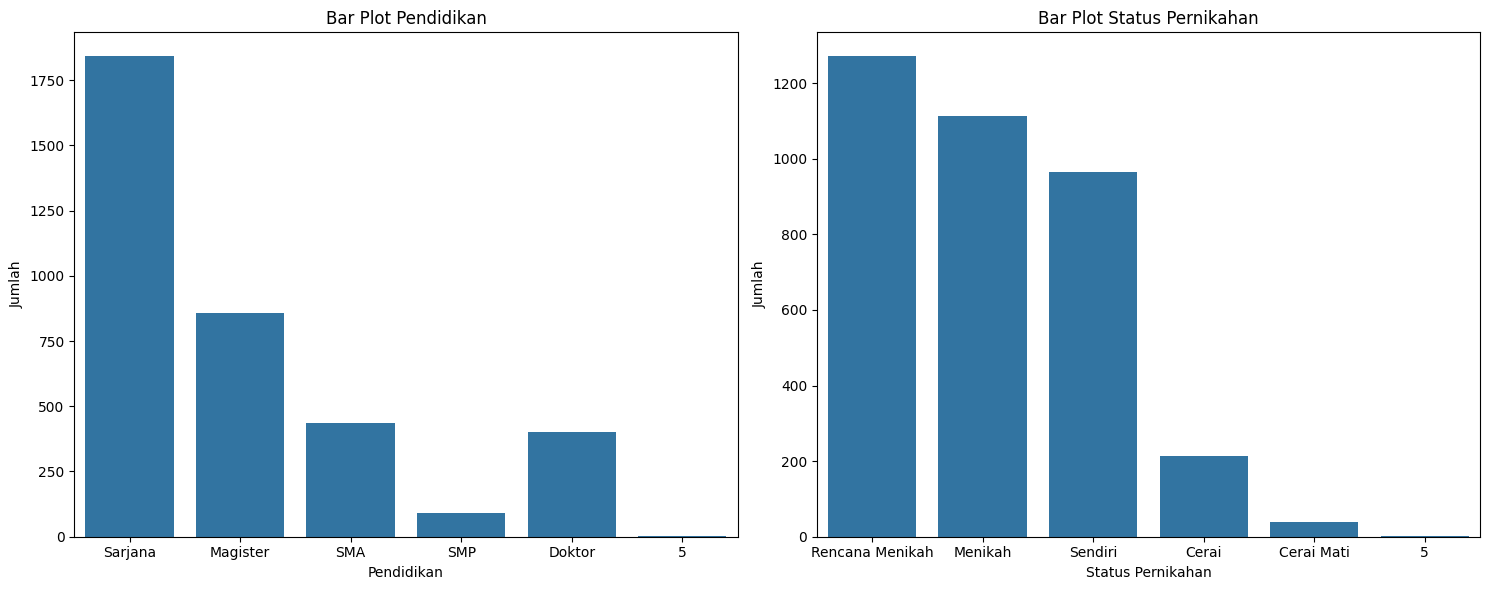

In [ ]:
# Membuat dua bar plot terpisah
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar plot untuk pendidikan
sns.countplot(data=df_train, x='pendidikan', ax=axes[0])
axes[0].set_title('Bar Plot Pendidikan')
axes[0].set_xlabel('Pendidikan')
axes[0].set_ylabel('Jumlah')

# Bar plot untuk status pernikahan
sns.countplot(data=df_train, x='status_pernikahan', ax=axes[1])
axes[1].set_title('Bar Plot Status Pernikahan')
axes[1].set_xlabel('Status Pernikahan')
axes[1].set_ylabel('Jumlah')

plt.tight_layout()
plt.show()

**Insight :** 
1. Tiap kategori memiliki perbedaan jumlah data yang cukup tinggi
2. Pada pendidikan maupun status_pernikahan terdapat kategori `5` yang tidak diketahui maksudnya, sehingga perlu dilakukan drop

## 3. Apakah terdapat outlier?

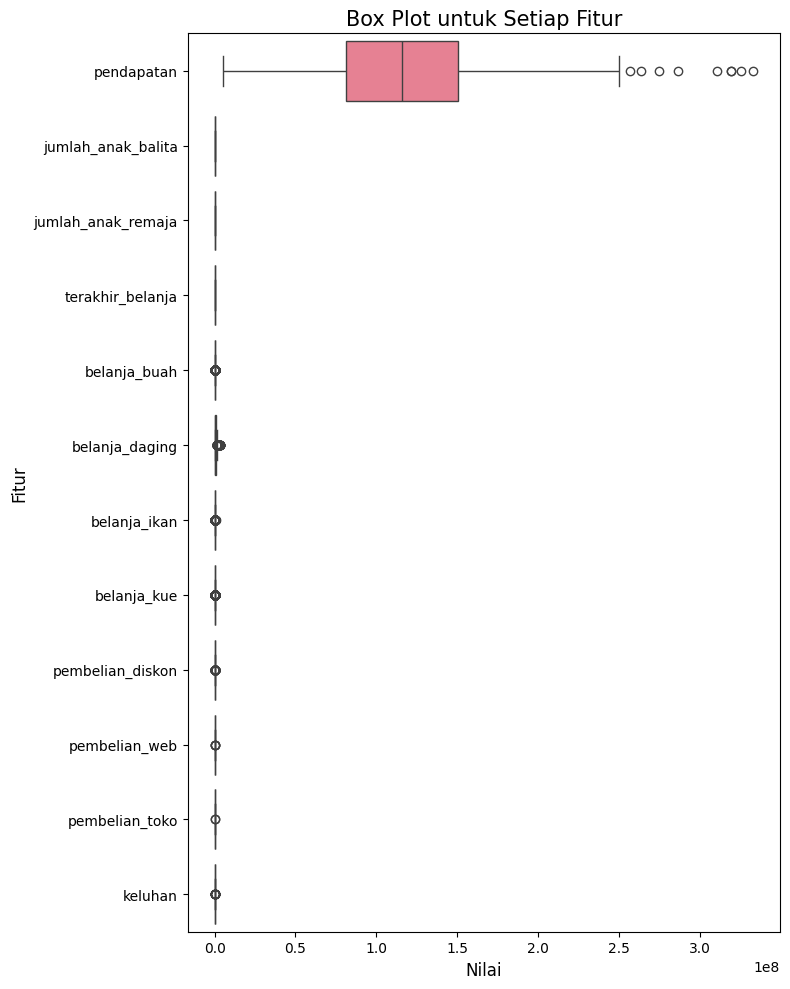

In [ ]:
kolom = df_train.columns

# Set up figure and axes
fig, axes = plt.subplots(figsize=(8, 10))

# Plot the box plot
sns.boxplot(data=df_train.drop(columns=kolom[0]), orient='h', ax=axes)

# Set title and labels
axes.set_title('Box Plot untuk Setiap Fitur', fontsize=15, loc='center')
axes.set_ylabel('Fitur', fontsize=12)
axes.set_xlabel('Nilai', fontsize=12)

plt.tight_layout()
plt.show()

**Insight :** 
1. Hanya fitur `jumlah_anak_balita`,`jumlah_anak_remaja`, dan `terakhir_belanja` yang tidak memiliki outlier
2. Outlier yang terjadi memiliki kemungkinan terjadi secara alami sehingga tidak perlu dilakukan trimming

## 4. Apakah datanya balance?

In [ ]:
y_train.value_counts()

jumlah_promosi
0                 983
5                 557
1                 515
4                 515
3                 472
2                 389
6                 386
Name: count, dtype: int64

**Insight :** Perbedaan nilainya tidak terlalu jauh, memungkinkan untuk dilakukan balancing data dengan metode SMOTE dan seimbangkan di nilai tengah

# **Feature Engineering**

## Split Data

In [ ]:
X = df_train
y = y_train
X_train,X_test,y_train,y_test =train_test_split(X,y,test_size=0.2,random_state=200)

## Missing Value Handling

In [ ]:
# df_train.dropna(inplace=True)

In [ ]:
# Menyamakan indeks pada data y dengan data X yang sudah di drop outlier
# y_train_MV = df_label_train.loc[df_train.index]

## Outlier Handling

In [ ]:
skewed_column = highly_skewed+moderately_skewed
skewed_column.remove("keluhan") # memiliki variasa rendah



# Metode Capping untuk Distribusi Skew
winsorizer_skewed = Winsorizer(capping_method='iqr',
                            tail='both',
                            fold=3,
                            variables=skewed_column,
                            missing_values='ignore')

# Fit & Transforming X_train 
X_train_capped = winsorizer_skewed.fit_transform(X_train)
X_test_capped = winsorizer_skewed.transform(X_test)

In [ ]:
# Plot Distribution Comparison
def outlier_handling_plot_comparison(df_before, df_after, variable):
    """
    This function is created to plot histograms and boxplots for a variable before and after outlier handling
    
    Parameters:
    - df_before (pandas.DataFrame): DataFrame before outlier handling
    - df_after (pandas.DataFrame): DataFrame after outlier handling
    - variable (str): The variable to plot
    
    Example: 
    num_cols = ['numeric_column']                                   <- Enter the numeric column
    for col in num_cols:                                            <- make a for loop in numeric column to access every columns
        plot_distribution_comparison(X_train, X_train_capped, col)  <- put X_train, X_train_capped, and columns in the variable

    """
    # Figure Size, and Super Title based on variable
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))                               
    fig.suptitle(f'{variable} - Distribution Before and After Outlier Handling')

    # Plot Histogram Before
    sns.histplot(df_before[variable], bins=30, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Histogram Before')

    # Plot Boxplot Before
    sns.boxplot(y=df_before[variable], ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title('Boxplot Before')

    # Plot Histogram After
    sns.histplot(df_after[variable], bins=30, ax=axes[0, 1], color='skyblue')
    axes[0, 1].set_title('Histogram After')

    # Plot Boxplot After
    sns.boxplot(y=df_after[variable], ax=axes[1, 1], color='lightgreen')
    axes[1, 1].set_title('Boxplot After')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


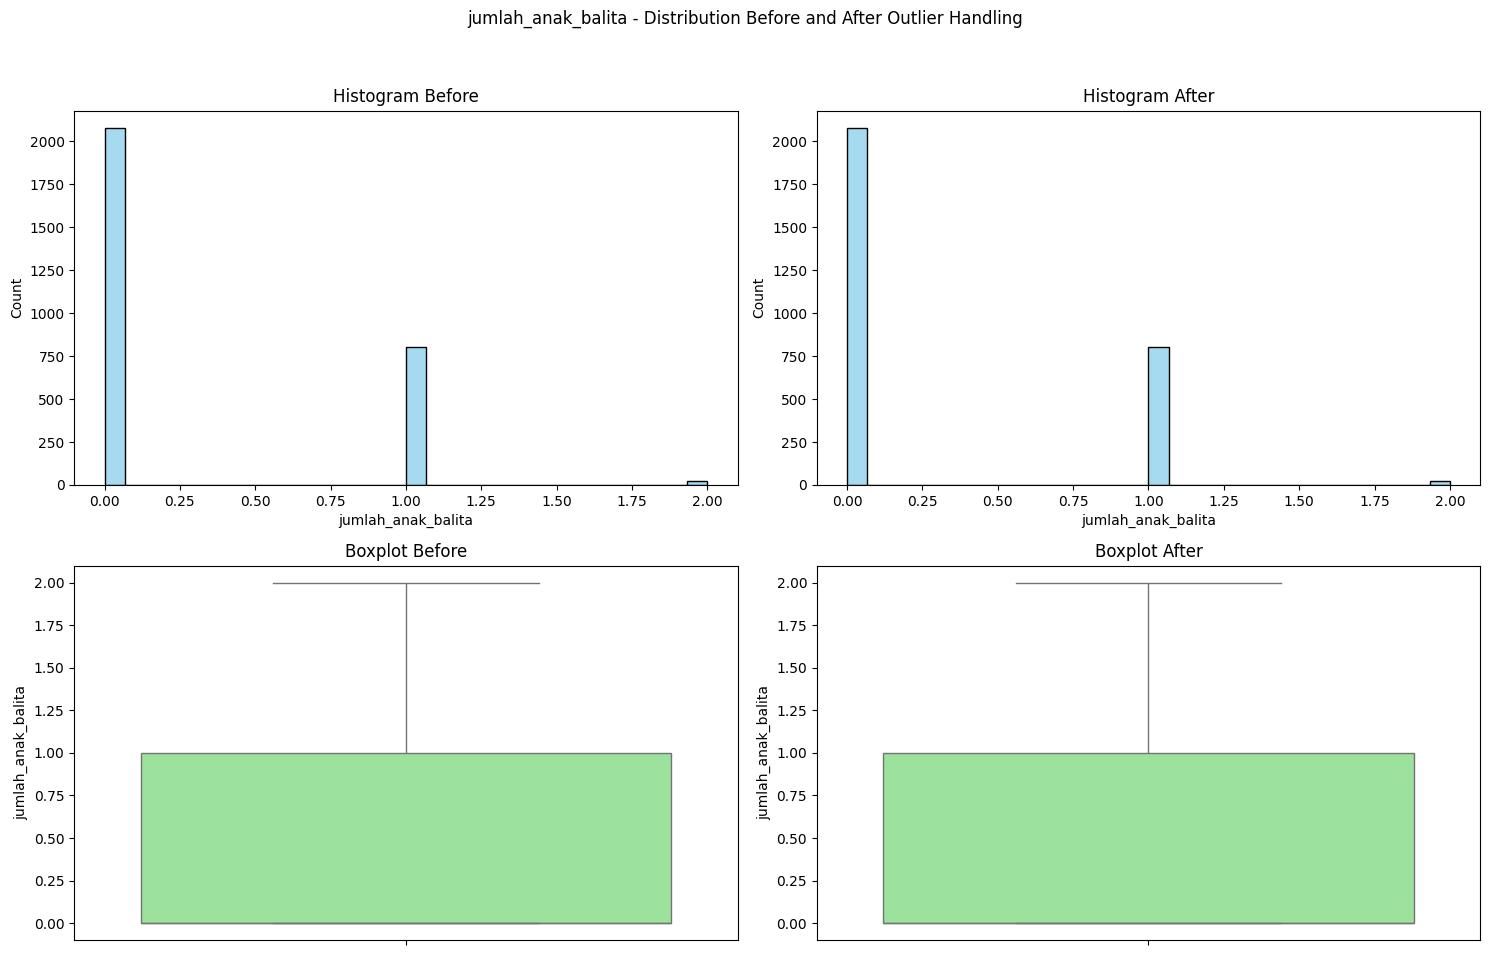

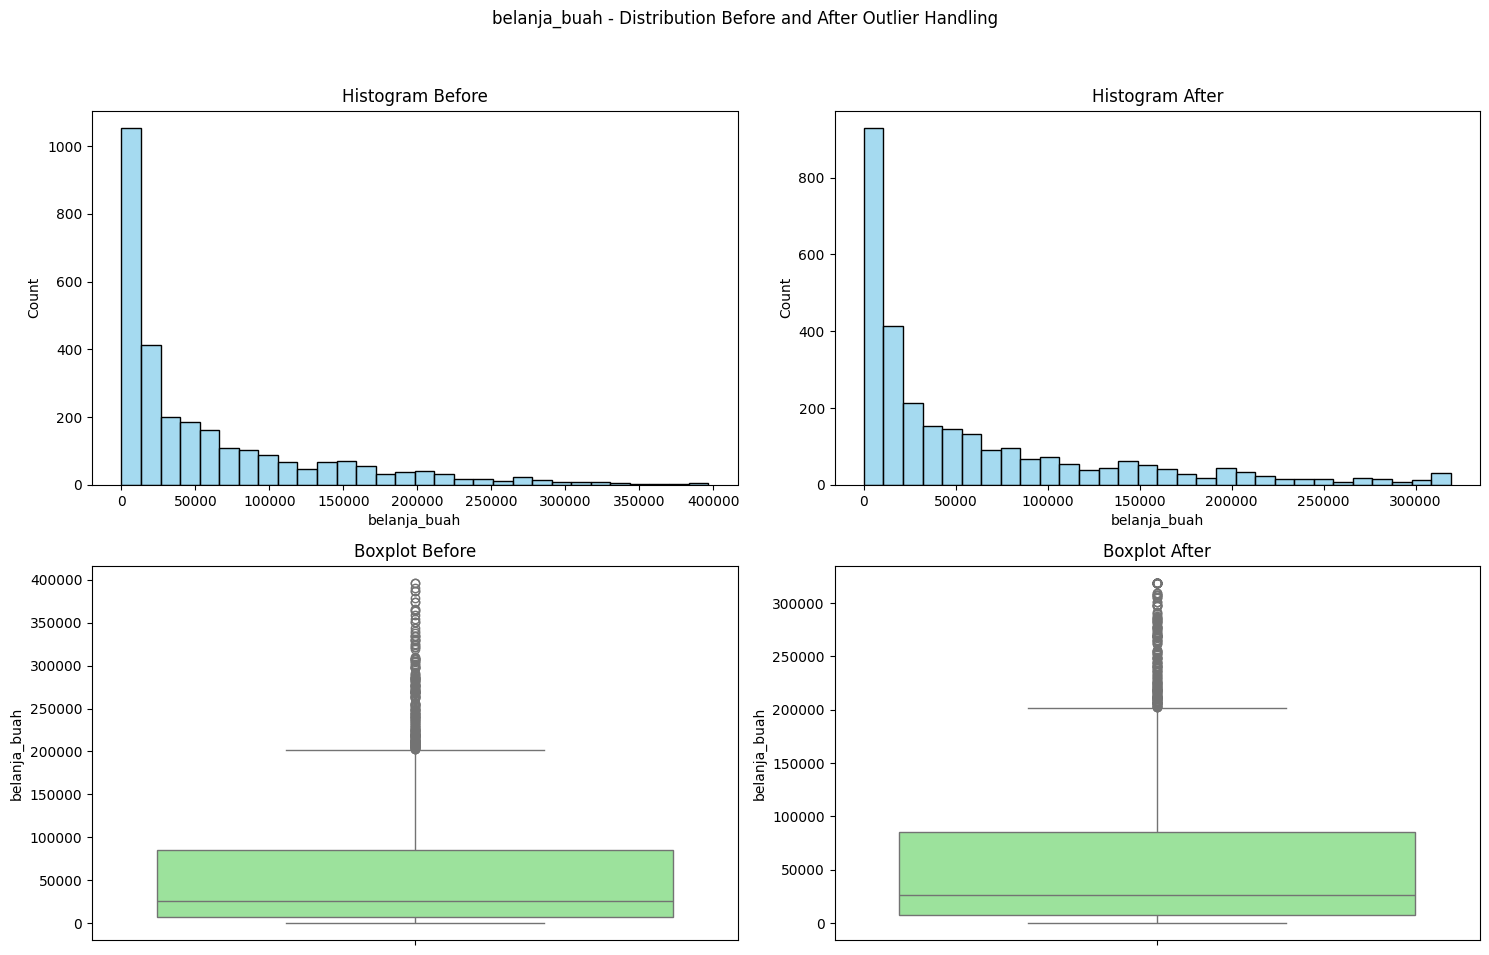

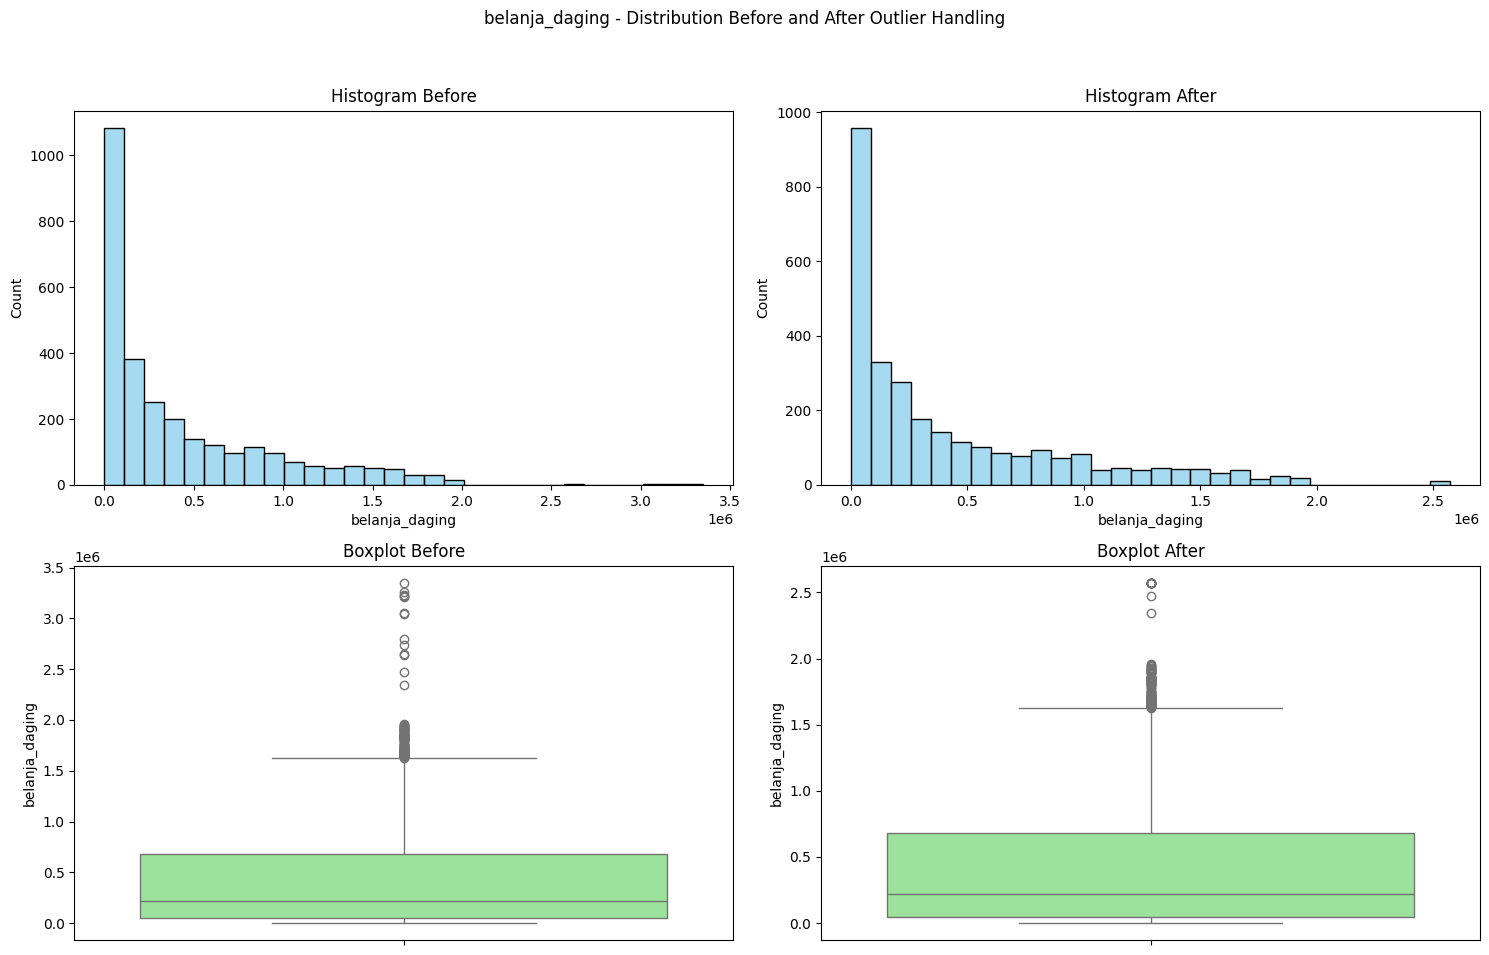

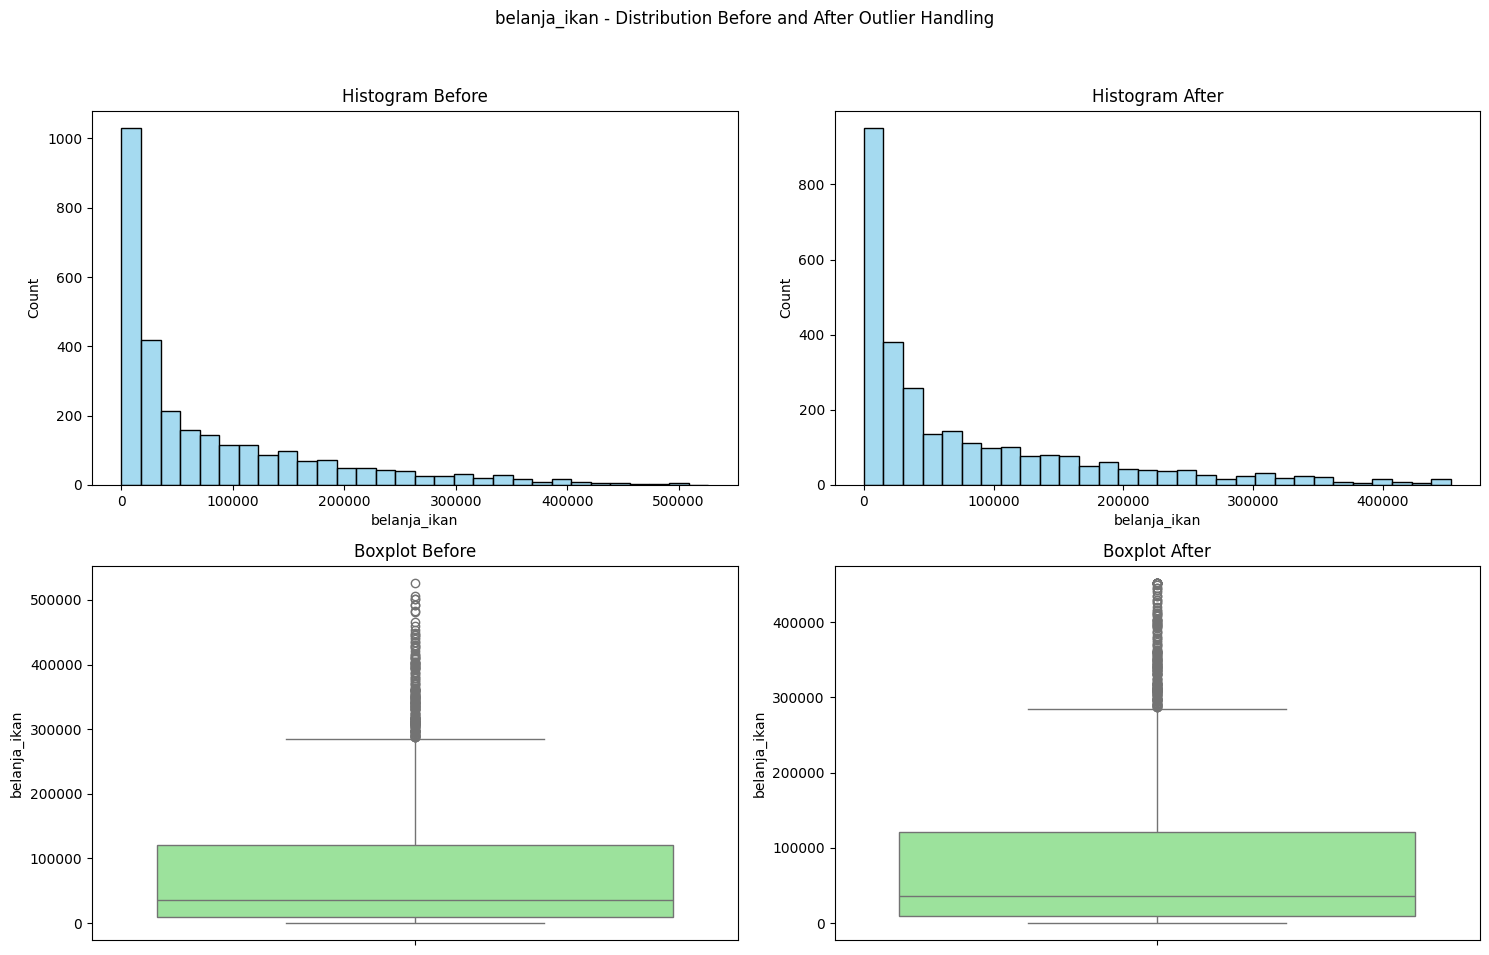

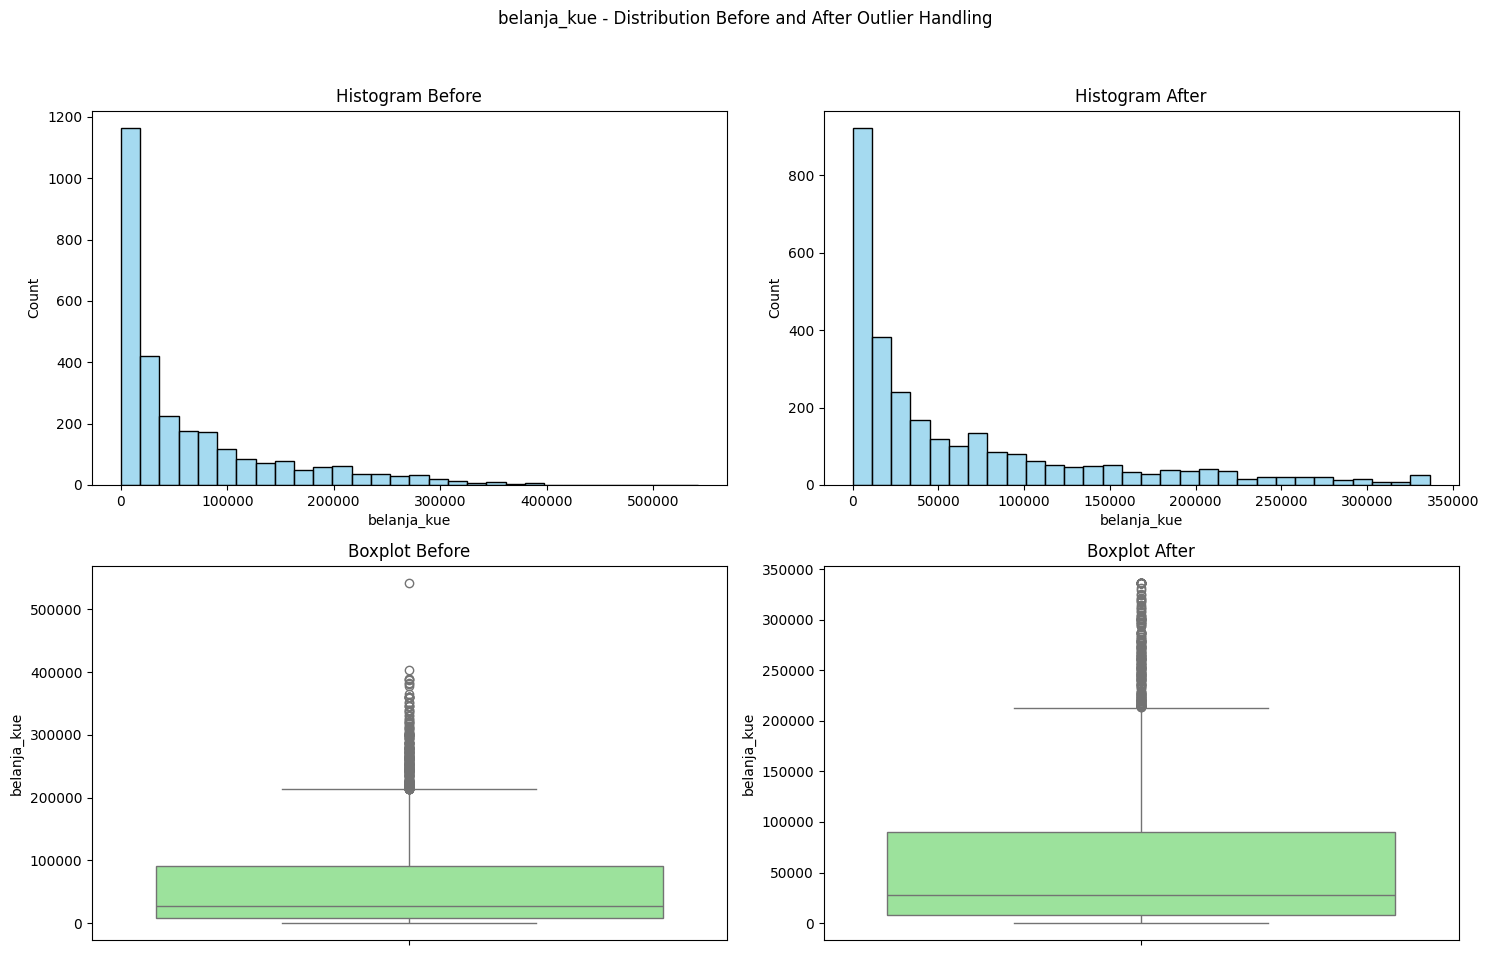

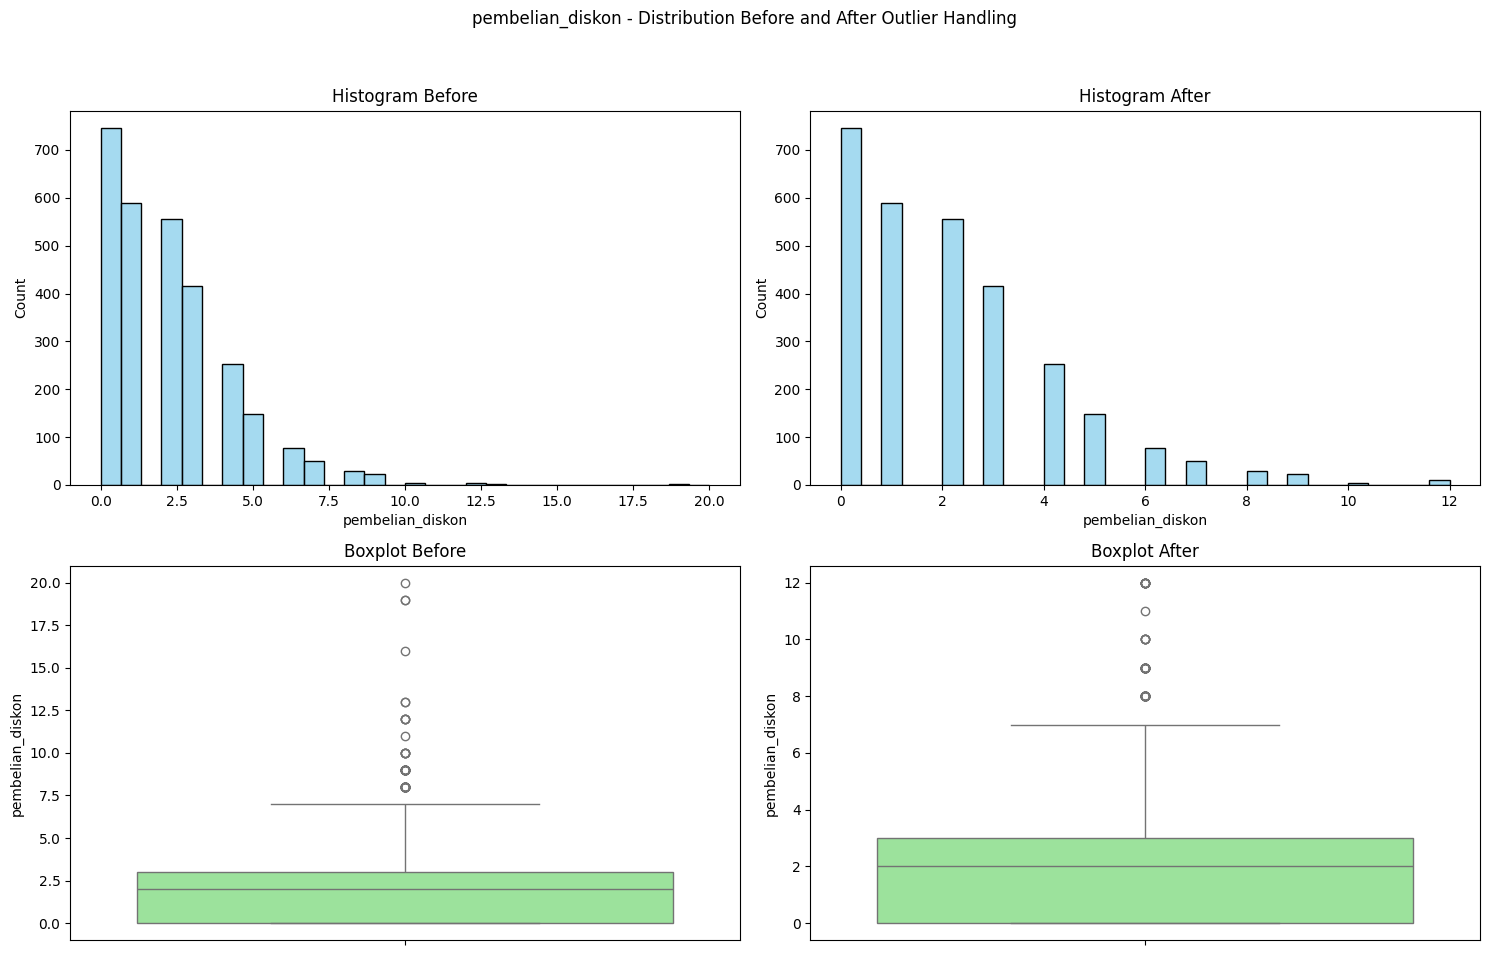

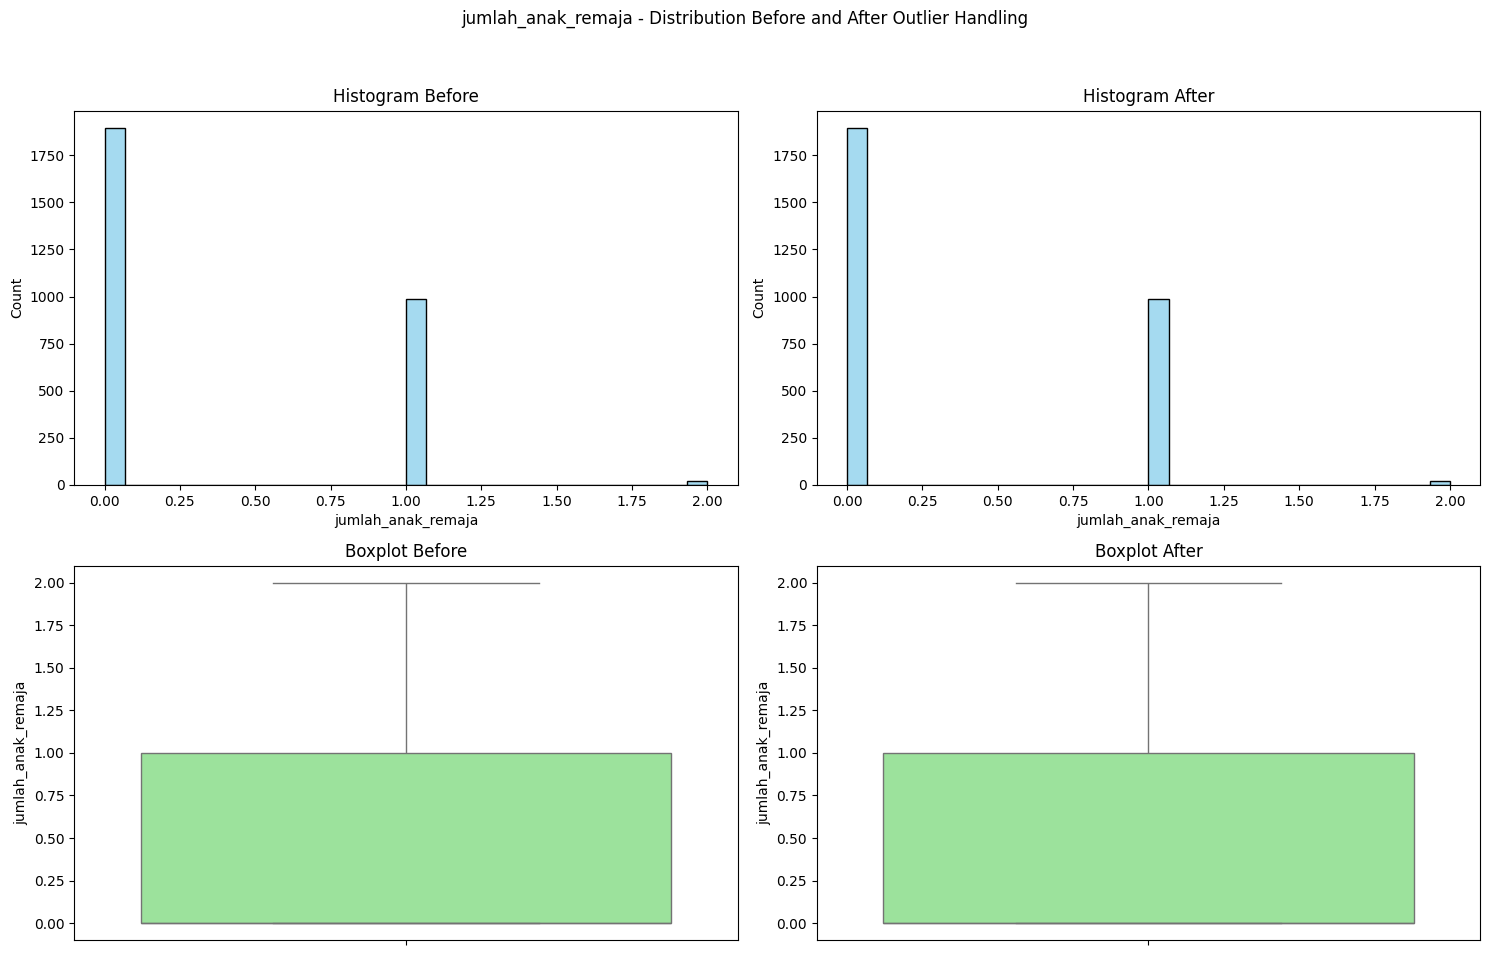

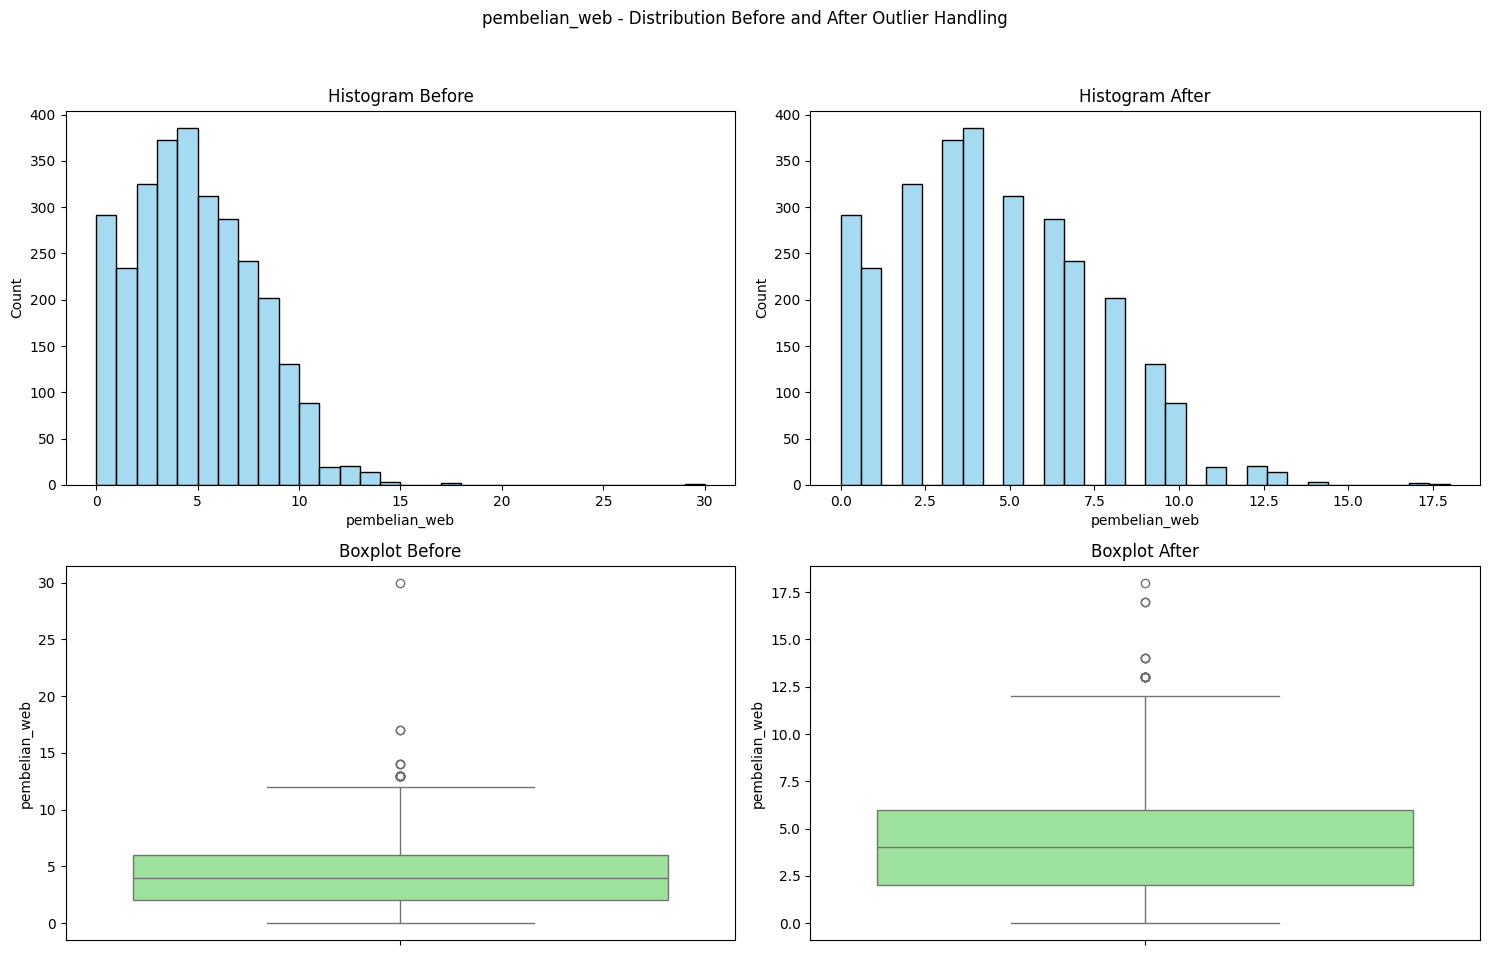

In [ ]:
for col in skewed_column:
    outlier_handling_plot_comparison(X_train, X_train_capped, col)

Beberapa masih memiliki outlier sehingga untuk scaling dan feature selection perlu disesuaikan

## Feature Selection

In [ ]:
X_train_capped

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
1763,1973,Sarjana,Rencana Menikah,138302622.0,0.0,0.0,11.0,54846.0,955824.0,244421.0,80854.0,0.0,6.0,7.0,0.0,NaN
1431,1968,Sarjana,Rencana Menikah,90325000.0,2.0,1.0,81.0,4046.0,62713.0,12138.0,4046.0,3.0,4.0,6.0,0.0,2013-11-12
3482,1949,NaN,Cerai,117010000.0,0.0,1.0,70.0,0.0,50575.0,8092.0,8092.0,0.0,4.0,4.0,0.0,2013-10-13
100,1968,Sarjana,Rencana Menikah,100686641.0,0.0,1.0,NaN,14524.0,63666.0,42277.0,18320.0,1.0,4.0,2.0,0.0,NaN
1465,1958,Magister,Rencana Menikah,117221809.0,0.0,1.0,69.0,3134.0,125704.0,2223.0,20724.0,1.0,4.0,11.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,1968,Sarjana,Sendiri,143622000.0,0.0,NaN,68.0,107219.0,530026.0,254898.0,119357.0,NaN,5.0,6.0,0.0,NaN
1860,1949,Magister,Menikah,160275902.0,0.0,0.0,51.0,171649.0,970380.0,231210.0,89350.0,1.0,2.0,6.0,0.0,NaN
784,1978,Sarjana,Sendiri,97163000.0,0.0,1.0,46.0,2023.0,NaN,0.0,8092.0,1.0,2.0,2.0,0.0,2013-07-03
617,1969,Magister,Sendiri,126368979.0,0.0,0.0,73.0,45678.0,863781.0,130640.0,NaN,0.0,2.0,NaN,0.0,NaN


In [ ]:
X_train_capped

,tahun_kelahiran,pendidikan,status_pernikahan,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan,tanggal_menjadi_anggota
1763,1973,Sarjana,Rencana Menikah,138302622.0,0.0,0.0,11.0,54846.0,955824.0,244421.0,80854.0,0.0,6.0,7.0,0.0,NaN
1431,1968,Sarjana,Rencana Menikah,90325000.0,2.0,1.0,81.0,4046.0,62713.0,12138.0,4046.0,3.0,4.0,6.0,0.0,2013-11-12
3482,1949,NaN,Cerai,117010000.0,0.0,1.0,70.0,0.0,50575.0,8092.0,8092.0,0.0,4.0,4.0,0.0,2013-10-13
100,1968,Sarjana,Rencana Menikah,100686641.0,0.0,1.0,NaN,14524.0,63666.0,42277.0,18320.0,1.0,4.0,2.0,0.0,NaN
1465,1958,Magister,Rencana Menikah,117221809.0,0.0,1.0,69.0,3134.0,125704.0,2223.0,20724.0,1.0,4.0,11.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,1968,Sarjana,Sendiri,143622000.0,0.0,NaN,68.0,107219.0,530026.0,254898.0,119357.0,NaN,5.0,6.0,0.0,NaN
1860,1949,Magister,Menikah,160275902.0,0.0,0.0,51.0,171649.0,970380.0,231210.0,89350.0,1.0,2.0,6.0,0.0,NaN
784,1978,Sarjana,Sendiri,97163000.0,0.0,1.0,46.0,2023.0,NaN,0.0,8092.0,1.0,2.0,2.0,0.0,2013-07-03
617,1969,Magister,Sendiri,126368979.0,0.0,0.0,73.0,45678.0,863781.0,130640.0,NaN,0.0,2.0,NaN,0.0,NaN


In [ ]:
p_values = []
interpretation = []
cols = []

col_cat = ['pendidikan','status_pernikahan']
# Menggunakan pointbiserialr untuk menghitung korelasi
for col in col_cat:
    contingency_table = pd.crosstab(X_train_capped[col],y_train['jumlah_promosi'])
    res = stats.chi2_contingency(contingency_table)
    
    p_values.append(res.pvalue)
    cols.append(col)

    if res.pvalue < 0.05:
        interpretation.append('Significant Correlation')
    else:
        interpretation.append('No Significant Correlation')

# Create DataFrame with all numeric values
correlation_df_cat = pd.DataFrame({
    'Column Name': cols,
    'P-value': p_values
})

# Add 'Interpretation' column with interpretation values
correlation_df_cat['Interpretation'] = interpretation

correlation_df_cat

,Column Name,P-value,Interpretation
0,pendidikan,3.940533e-31,Significant Correlation
1,status_pernikahan,2.645905e-17,Significant Correlation


In [ ]:
p_values = []
interpretation = []
cols = []

col_num = list(X_train_capped.columns)
col_num.remove('pendidikan')
col_num.remove('status_pernikahan')
col_num.remove('tanggal_menjadi_anggota')
# Menggunakan pointbiserialr untuk menghitung korelasi
for col in col_num:
    # Menghitung korelasi Spearman
    corr, p_value = spearmanr(X_train_capped[col], y_train['jumlah_promosi'], nan_policy='omit')

    print(col)
    print("Korelasi Spearman:", corr)
    print("Nilai p:", p_value)
    print("-"*10)

    
    p_values.append(p_value)
    cols.append(col)

    if p_value < 0.05 and (corr > 0.1 or corr < -0.1):
        interpretation.append('Significant Correlation')
    else:
        interpretation.append('No Significant Correlation')

# Create DataFrame with all numeric values
correlation_df_num = pd.DataFrame({
    'Column Name': cols,
    'P-value': p_values
})

# Add 'Interpretation' column with interpretation values
correlation_df_num['Interpretation'] = interpretation

correlation_df_num 


tahun_kelahiran
Korelasi Spearman: -0.07582815257190399
Nilai p: 2.73921894828174e-05
----------
pendapatan
Korelasi Spearman: 0.2700844916024288
Nilai p: 1.1386498395289082e-49
----------
jumlah_anak_balita
Korelasi Spearman: -0.21782701230507964
Nilai p: 1.6114313233993444e-32
----------
jumlah_anak_remaja
Korelasi Spearman: -0.20306227448976902
Nilai p: 2.3968933042316344e-28
----------
terakhir_belanja
Korelasi Spearman: -0.13631388142642453
Nilai p: 1.3888156906172633e-13
----------
belanja_buah
Korelasi Spearman: 0.22672975279318122
Nilai p: 3.5007674673415035e-35
----------
belanja_daging
Korelasi Spearman: 0.3079484910794368
Nilai p: 4.526070442137762e-65
----------
belanja_ikan
Korelasi Spearman: 0.18555042696901186
Nilai p: 6.264265254058574e-24
----------
belanja_kue
Korelasi Spearman: 0.20756716082713025
Nilai p: 2.438234062218437e-29
----------
pembelian_diskon
Korelasi Spearman: -0.019130132695408184
Nilai p: 0.3026686498339167
----------
pembelian_web
Korelasi Spearman: 

,Column Name,P-value,Interpretation
0,tahun_kelahiran,2.739219e-05,No Significant Correlation
1,pendapatan,1.138650e-49,Significant Correlation
2,jumlah_anak_balita,1.611431e-32,Significant Correlation
3,jumlah_anak_remaja,2.396893e-28,Significant Correlation
4,terakhir_belanja,1.388816e-13,Significant Correlation
5,belanja_buah,3.500767e-35,Significant Correlation
6,belanja_daging,4.526070e-65,Significant Correlation
7,belanja_ikan,6.264265e-24,Significant Correlation
8,belanja_kue,2.438234e-29,Significant Correlation
9,pembelian_diskon,3.026686e-01,No Significant Correlation


In [ ]:
selected_column = list(correlation_df_cat['Column Name'])+list(correlation_df_num['Column Name'])
selected_column

['pendidikan',
 'status_pernikahan',
 'tahun_kelahiran',
 'pendapatan',
 'jumlah_anak_balita',
 'jumlah_anak_remaja',
 'terakhir_belanja',
 'belanja_buah',
 'belanja_daging',
 'belanja_ikan',
 'belanja_kue',
 'pembelian_diskon',
 'pembelian_web',
 'pembelian_toko',
 'keluhan']

In [ ]:
X_train_selected = X_train_capped[selected_column]

In [ ]:
X_train_selected

,pendidikan,status_pernikahan,tahun_kelahiran,pendapatan,jumlah_anak_balita,jumlah_anak_remaja,terakhir_belanja,belanja_buah,belanja_daging,belanja_ikan,belanja_kue,pembelian_diskon,pembelian_web,pembelian_toko,keluhan
1763,Sarjana,Rencana Menikah,1973,138302622.0,0.0,0.0,11.0,54846.0,955824.0,244421.0,80854.0,0.0,6.0,7.0,0.0
1431,Sarjana,Rencana Menikah,1968,90325000.0,2.0,1.0,81.0,4046.0,62713.0,12138.0,4046.0,3.0,4.0,6.0,0.0
3482,NaN,Cerai,1949,117010000.0,0.0,1.0,70.0,0.0,50575.0,8092.0,8092.0,0.0,4.0,4.0,0.0
100,Sarjana,Rencana Menikah,1968,100686641.0,0.0,1.0,NaN,14524.0,63666.0,42277.0,18320.0,1.0,4.0,2.0,0.0
1465,Magister,Rencana Menikah,1958,117221809.0,0.0,1.0,69.0,3134.0,125704.0,2223.0,20724.0,1.0,4.0,11.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2858,Sarjana,Sendiri,1968,143622000.0,0.0,NaN,68.0,107219.0,530026.0,254898.0,119357.0,NaN,5.0,6.0,0.0
1860,Magister,Menikah,1949,160275902.0,0.0,0.0,51.0,171649.0,970380.0,231210.0,89350.0,1.0,2.0,6.0,0.0
784,Sarjana,Sendiri,1978,97163000.0,0.0,1.0,46.0,2023.0,NaN,0.0,8092.0,1.0,2.0,2.0,0.0
617,Magister,Sendiri,1969,126368979.0,0.0,0.0,73.0,45678.0,863781.0,130640.0,NaN,0.0,2.0,NaN,0.0


## Encoding

## Scaling

# **Balancing Dataset**

# **Modelling**

In [ ]:
# Inisialisasi model XGBoost
model = xgb.XGBClassifier()

# Mengonversi DataFrame menjadi DMatrix dengan mengatur enable_categorical=True
dtrain = xgb.DMatrix(data=X_train_selected, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(data=X_test[selected_column], label=y_test, enable_categorical=True)

# Inisialisasi dan melatih model
params = {'objective': 'binary:logistic', 'eval_metric': 'logloss'}
model = xgb.train(params, dtrain)

# # Melatih model
# model.fit(X_train_selected, y_train)

# Memprediksi kelas pada data uji
y_pred = model.predict(dtest)

# Menghitung F1-Score
macro_f1 = f1_score(y_test, y_pred, average='macro')

print("Macro F1-Score:", macro_f1)

ValueError: DataFrame.dtypes for data must be int, float, bool or category. When categorical type is supplied, The experimental DMatrix parameter`enable_categorical` must be set to `True`.  Invalid columns:pendidikan: object, status_pernikahan: object

# **Model Evaluation**